In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [3]:
# Load CSV labels
labels_df = pd.read_csv('/kaggle/input/labels-data/labels (2).csv')

# Path to the images directory
images_dir = '/kaggle/input/watermark-data/with_watermark'

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming watermark is in grayscale
    image = cv2.resize(image, (128, 128))  # Resize to consistent size
    image = image / 255.0  # Normalize
    return image

# Load and preprocess images
images = []
labels = []
for idx, row in labels_df.iterrows():
    image_path = os.path.join(images_dir, row['filename'])
    label = row['labels']
    image = load_and_preprocess_image(image_path)
    images.append(image)
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images).reshape(-1, 128, 128, 1)  # Reshape for CNN input
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
labels = to_categorical(integer_encoded, num_classes=num_classes)


In [6]:
# Define the CNN architecture
input_img = Input(shape=(128, 128, 1), name='image_input')

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Reshape for RNN
x = Reshape((16, 2048))(x)  # Adjust dimensions as necessary

# Define the RNN architecture
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Flatten and add dense layer for classification
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=input_img, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 256)        │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 16, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,470 (12.40 MB)

 Trainable params: 3,249,022 (12.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
# Train the model
history = model.fit(images, labels, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0060 - loss: 4.1077 - val_accuracy: 0.0000e+00 - val_loss: 4.1155
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step - accuracy: 0.1486 - loss: 3.6870 - val_accuracy: 0.1429 - val_loss: 4.0781
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - accuracy: 0.2476 - loss: 3.1197 - val_accuracy: 0.0000e+00 - val_loss: 4.1046
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 0.3718 - loss: 2.7246 - val_accuracy: 0.1429 - val_loss: 4.0506
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step - accuracy: 0.4750 - loss: 2.3551 - val_accuracy: 0.0000e+00 - val_loss: 4.0602
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - accuracy: 0.5424 - loss: 1.9389 - val_accuracy: 0.0000e+00 - val_loss: 4.0336
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.6194 - loss: 1.5589 - val_accuracy: 0.0000e+00 - val_loss: 4.0946
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 650ms/step - accuracy: 0.6736 - loss: 1.2881 - val_accuracy: 

In [8]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(images, labels)
print(f"Validation Accuracy: {val_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.0091 - loss: 7.5662
Validation Accuracy: 0.01


In [14]:
# Function to predict watermark text from user input image
def predict_watermark(image_path):
    image = load_and_preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Expand dimensions to match model input
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(predicted_label)[0]

# Usage example
user_input_image_path = '/kaggle/input/watermark-data/with_watermark/1 (60).jpg'
predicted_watermark_text = predict_watermark(user_input_image_path)
print(f"Predicted Watermark Text: {predicted_watermark_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Watermark Text: SIMON SEZ IT


In [15]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
# Load CSV labels
labels_df = pd.read_csv('/kaggle/input/labels-data/labels (2).csv')

# Path to the images directory
images_dir = '/kaggle/input/watermark-data/with_watermark'

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming watermark is in grayscale
    image = cv2.resize(image, (128, 128))  # Resize to consistent size
    image = image / 255.0  # Normalize
    return image

# Load and preprocess images
images = []
labels = []
for idx, row in labels_df.iterrows():
    image_path = os.path.join(images_dir, row['filename'])
    label = row['labels']
    image = load_and_preprocess_image(image_path)
    images.append(image)
    labels.append(label)

# Convert lists to numpy arrays
images = np.array(images).reshape(-1, 128, 128, 1)  # Reshape for CNN input
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
labels = to_categorical(integer_encoded, num_classes=num_classes)


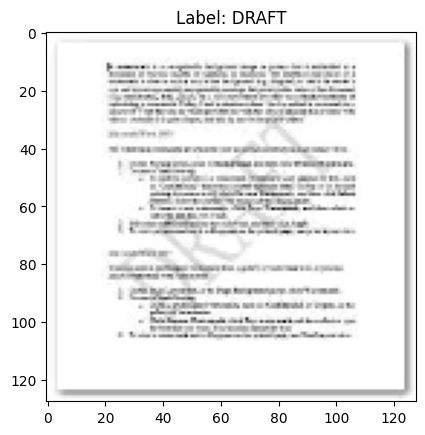

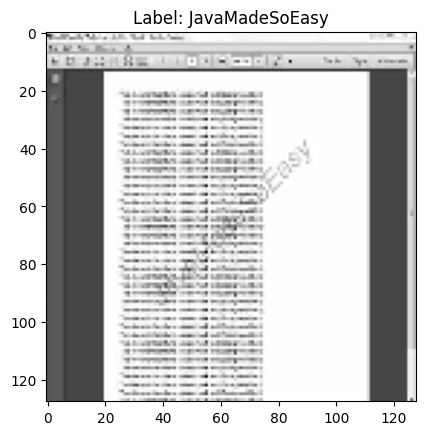

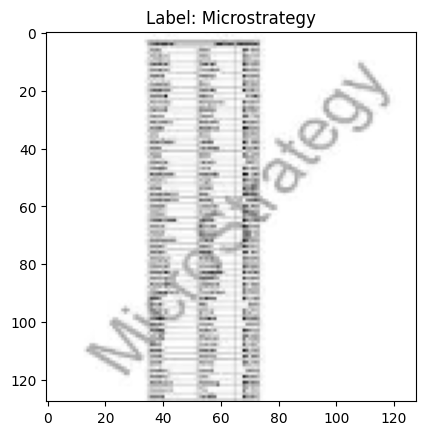

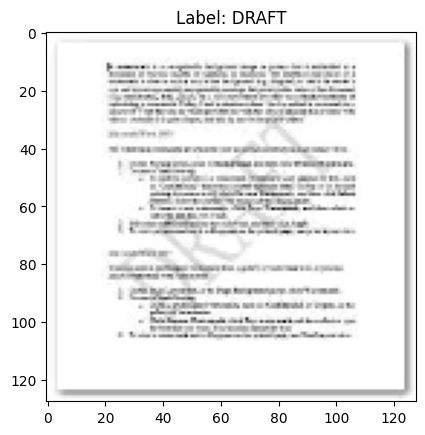

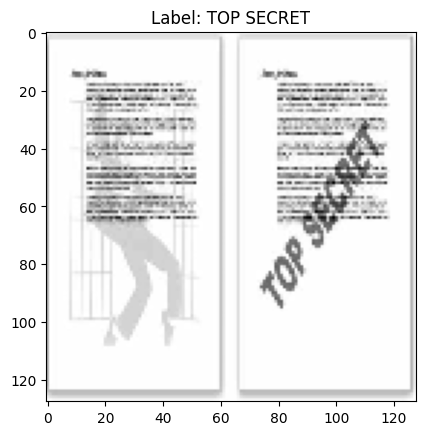

In [19]:
# Verify a few images and their labels
for i in range(5):
    image_path = os.path.join(images_dir, labels_df.iloc[i]['filename'])
    label = labels_df.iloc[i]['labels']
    image = load_and_preprocess_image(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()


In [21]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of data for validation
)

# Fit the data generator to the images
datagen.fit(images)

# Create generators for training and validation
train_generator = datagen.flow(images, labels, batch_size=32, subset='training')
validation_generator = datagen.flow(images, labels, batch_size=32, subset='validation')

In [23]:
# Define the CNN + RNN architecture
input_img = Input(shape=(128, 128, 1), name='image_input')

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Ensure the shape is compatible with LSTM
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Reshape for RNN
x = Reshape((16, 1024))(x)  # Adjust dimensions as necessary

# Define the RNN architecture
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Flatten and add dense layer for classification
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=input_img, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 16, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 16, 256)        │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 16, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497,086 (9.53 MB)

 Trainable params: 2,496,126 (9.52 MB)

 Non-trainable params: 960 (3.75 KB)

In [36]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 986ms/step - accuracy: 0.2095 - loss: 3.1634 - val_accuracy: 0.3000 - val_loss: 4.0253
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - accuracy: 0.2007 - loss: 2.9248 - val_accuracy: 0.3000 - val_loss: 4.0984
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step - accuracy: 0.3262 - loss: 2.8690 - val_accuracy: 0.3000 - val_loss: 4.2009
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 772ms/step - accuracy: 0.2823 - loss: 2.8369 - val_accuracy: 0.1000 - val_loss: 4.2961
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 882ms/step - accuracy: 0.3503 - loss: 2.3232 - val_accuracy: 0.2000 - val_loss: 4.4539
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 795ms/step - accuracy: 0.4618 - loss: 1.9565 - val_accuracy: 0.0000e+00 - val_loss: 4.5971
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step - accuracy: 0.5175 - loss: 1.9311 - val_accuracy: 0.3000 - val_loss: 4.6377
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.4350 - loss: 1.9399 - val_accuracy: 0.0000e+00 - v

In [37]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3000 - loss: 3.9813
Validation Accuracy: 0.30


In [38]:
# Function to predict watermark text from user input image
def predict_watermark(image_path):
    image = load_and_preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Expand dimensions to match model input
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(predicted_label)[0]


user_input_image_path = '/kaggle/input/watermark-data/with_watermark/1 (5).jpg'
predicted_watermark_text = predict_watermark(user_input_image_path)
print(f"Predicted Watermark Text: {predicted_watermark_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Watermark Text: DRAFT


In [39]:
# Save the final model
model.save('final_model.keras')

In [40]:

model.save('/kaggle/working/final_model.h5')
